# NanoDet-Plus Prediction

The demo notebook for the NanoDet-Plus model prediction in PyTorch can be found on the GitHub site of the NanoDet-Plus model and be accessed directly under the link: https://github.com/RangiLyu/nanodet/blob/main/demo/demo-inference-with-pytorch.ipynb.

For the use in Google Colab it has been slightly adapted in the following.

## Set up Libraries & mount Google Drive

First again the required libraries need to be importet and the Googel Drive needs to be mounted.

In [ ]:
# Import libraries
import tensorflow as tf
import os
import cv2
import torch
import IPython
import shutil
from psutil import virtual_memory
from matplotlib import pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


## Google Colab Setup

Since the nanoDet-Plus setup is required again to gain all the folders, also a GPU with CUDA is used and checked in the following.

Check if a GPU is available:

In [ ]:
# Check GPU
print(tf.test.gpu_device_name())

/device:GPU:0


Afterwards the details of the GPU provided by Google and CUDA version 11.2 are checked:

In [ ]:
# Retain GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jul  2 05:22:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    38W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check the random access memory provided by Google.

In [ ]:
# Retain RAM info
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## NanoDet-Plus Setup

Now the NanoDet-Plus GitHub repository can be cloned:

In [ ]:
# Clone repository
!git clone https://github.com/RangiLyu/nanodet.git

Cloning into 'nanodet'...
remote: Enumerating objects: 2515, done.
remote: Total 2515 (delta 0), reused 0 (delta 0), pack-reused 2515
Receiving objects: 100% (2515/2515), 5.23 MiB | 32.67 MiB/s, done.
Resolving deltas: 100% (1472/1472), done.


And the requirements according to the instructions can be installed:

In [ ]:
# Install requirements
%cd nanodet
!pip install -r requirements.txt

/content/nanodet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.5 MB/s 
     |████████████████████████████████| 13.1 MB 10.7 MB/s 
     |████████████████████████████████| 585 kB 46.5 MB/s 
     |████████████████████████████████| 419 kB 60.1 MB/s 
     |████████████████████████████████| 596 kB 59.6 MB/s 
     |████████████████████████████████| 117 kB 67.4 MB/s 
     |████████████████████████████████| 140 kB 65.9 MB/s 
     |████████████████████████████████| 1.1 MB 13.8 MB/s 
     |████████████████████████████████| 498 kB 56.5 MB/s 
     |████████████████████████████████| 232 kB 63.1 MB/s 
     |████████████████████████████████| 5.2 MB 50.4 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 65.9 MB/s 
     |████████████████████████████████| 144 kB 57.7 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
  Created wheel for

After restarting the runtime and installing the libraries again the setup of nanodet can take place.

In [ ]:
# Check content
!ls /content/nanodet

config		   demo_libtorch  demo_openvino  nanodet	   setup.py
demo		   demo_mnn	  docs		 README.md	   tests
demo_android_ncnn  demo_ncnn	  LICENSE	 requirements.txt  tools


In [ ]:
# Set up NanoDet
%cd /content/nanodet
!python setup.py develop

/content/nanodet
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:484: UserWarning: Normalizing '1.0.0-alpha' to '1.0.0a0'
  warnings.warn(tmpl.format(**locals()))
running develop
running egg_info
creating nanodet.egg-info
writing nanodet.egg-info/PKG-INFO
writing dependency_links to nanodet.egg-info/dependency_links.txt
writing top-level names to nanodet.egg-info/top_level.txt
writing manifest file 'nanodet.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'nanodet.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/nanodet.egg-link (link to .)
Adding nanodet 1.0.0a0 to easy-install.pth file

Installed /content/nanodet
Processing dependencies for nanodet==1.0.0a0
Finished processing dependencies for nanodet==1.0.0a0


Qick check whether the module has been found:

In [ ]:
import nanodet
nanodet.__version__

'1.0.0-alpha'

## Set Environmental Parameters

First the environmental parameters for cuDNN are set.

cuDNN is a GPU-accelerated library of deep neural network primitives and offers highly tweaked operations for standard routines such as forward and backward con-volution, pooling, normalization, and activation layers. [1]

---

[1]  “CUDA Deep Neural Network.” NVIDIA Developer, 2 Sept. 2014, https://developer.nvidia.com/cudnn.



In [ ]:
# Set env params
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda')

In [ ]:
# Enable cuDNN & benchmark multiple convolution algorithms and select the fastest 
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

## Set Model Configuration and Logger

Afterwards some libraries from NanoDet-Plus need to be imported and a Fall image for test is copied to the NanoDet-Plus demo folder. Then the paths are defined and the configuration and the logger are loaded.

In [ ]:
# Import NanoDet-Plus libraries
from nanodet.util import cfg, load_config, Logger
from demo.demo import Predictor
from nanodet.util import overlay_bbox_cv
from IPython.display import display
from PIL import Image

In [ ]:
# Copy own image to demo folder
shutil.copy('/content/drive/MyDrive/MasterThesis/FallDataset/TestFrames/l_video (14) frame 345.png', '/content/nanodet/demo_mnn/imgs/fall_test.png')

'/content/nanodet/demo_mnn/imgs/fall_test.png'

In [ ]:
# Set paths
config_path = '/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/nanodet-plus-m_320_AdamW_ShuffleNetV2-05x_fall.yml'
model_path = '/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/model_best/model_best.ckpt'
image_path = '/content/nanodet/demo_mnn/imgs/fall_test.png'

In [ ]:
# Load config & logger
load_config(cfg, config_path)
logger = Logger(-1, use_tensorboard=False)

## Set Model Predictor

The predictor is defined and the results for the copied fall image can be detected.

In [ ]:
# Set predictor
predictor = Predictor(cfg, model_path, logger, device=device)

model size is  0.5x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth
Finish initialize NanoDet-Plus Head.


In [ ]:
# Retain results for image
meta, res = predictor.inference(image_path)

forward time: 0.019s | decode time: 0.005s | 

In [ ]:
# Show results
print(res[0])

{0: [[73.42593383789062, 124.33462524414062, 190.7919158935547, 213.43760681152344, 0.8674324750900269], [162.94558715820312, 121.28585815429688, 302.6273193359375, 213.30943298339844, 0.13385456800460815], [96.78225708007812, 150.3966522216797, 190.09580993652344, 214.4407501220703, 0.12168978154659271], [80.4122543334961, 150.5609130859375, 142.92745971679688, 209.3271484375, 0.12072404474020004], [75.03438568115234, 114.43380737304688, 186.70835876464844, 179.1163330078125, 0.07304126024246216]], 1: [[226.78851318359375, 89.03752899169922, 283.28570556640625, 175.50660705566406, 0.08221641182899475], [73.42593383789062, 124.33462524414062, 190.7919158935547, 213.43760681152344, 0.08064477145671844], [234.66798400878906, 106.00324249267578, 274.85504150390625, 163.7234344482422, 0.054469041526317596], [235.15635681152344, 121.36073303222656, 275.8749694824219, 178.88082885742188, 0.05341551452875137]]}


Comparing these results with teh TensorFLow Lite results, it can be seen, that whereas here the results contain the classes (0 for fall and 1 for adl) and the four values of the bounding boxes as well as the estimated percentage for the bounding box, the TensorFlow Lite model inference only provides 14 values times 1700.

The 1700 value come from the image size (=320x256) and header strides (=[8,16,32,64]), therefore 320/8x256/8 + 320/16x256/16 + 320/32x256/32 + 320/64x256/64 =1280+320+80+20 = 1700.

However the 14 values are not entirely clear since they could be 4 bounding boxes + 3 indices (batch_index, class_index, box_index) x 2 classes (fall and adl), but the order is not provided and the data seems to be normalized. Thus, it is not comparable with the output of the PyTorch model and the ncnn model with the provided post-processing by the NanoDet-Plus model is taken for implementation.

## Detection output visualisation

For the prediction only the resulting bounding boxes with a higher threshold than 35% will be shown on the image.

In [ ]:
# Set color of bounding boxes
def cv2_imshow(a, convert_bgr_to_rgb=True):
    """A replacement for cv2.imshow() for use in Jupyter notebooks.
    Args:
        a: np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
            image.
        convert_bgr_to_rgb: switch to convert BGR to RGB channel.
    """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if convert_bgr_to_rgb and a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [ ]:
# Get bounding boxes with threshold higher than 35%
result = overlay_bbox_cv(meta['raw_img'][0], res[0], cfg.class_names, score_thresh=0.35)

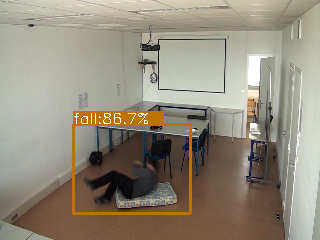

In [ ]:
# Show imgae with prediction bounding box
imshow_scale = 1.0
cv2_imshow(cv2.resize(result, None, fx=imshow_scale, fy=imshow_scale))

In this example image a fall is detected with an accuracy of about 87%, which shows that the model is working even though not with a mean average precision of over 90% as stated by Chen and Duan, but only with an mean average precision of 73,7%. [2]

---


[2]  Chen, Guang, and Xiaohui Duan. “Vision-Based Elderly Fall Detection Algorithm for Mobile Robot.” 2021 IEEE 4th International Conference on Electronics Technology (ICET), 2021, pp. 1197–202, https://doi.org/10.1109/ICET51757.2021.9450950.